In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
%matplotlib inline

reviews = pd.read_csv("development.csv")
evaluation = pd.read_csv("evaluation.csv")

In [2]:
import spacy
nlp = spacy.load('it_core_news_sm',disable=["parser","tagger","ner"])
def spacy_lemma_text(text):
    doc = nlp(text)
    tokens = [tok.lemma_.lower().strip() for tok in doc]
    tokens = ' '.join(tokens)
    return tokens
reviews['spacy'] = reviews['text'].apply(spacy_lemma_text)
evaluation['spacy'] = evaluation['text'].apply(spacy_lemma_text)

In [3]:
print(reviews[reviews['class']=='pos']['text'].str.len().mean())
print(reviews[reviews['class']=='neg']['text'].str.len().mean())
#negative reviews are longer
reviews['length']=reviews['text'].str.len()

624.5674278107721
864.228475384949


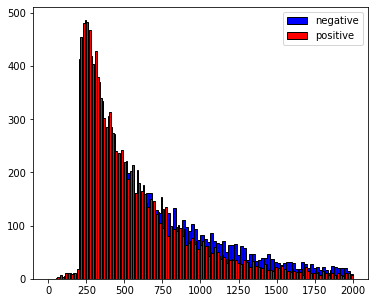

In [4]:
fig, ax = plt.subplots(figsize=(6, 5))
ax.hist(reviews[reviews['class']=='neg']['length'], color = 'blue', edgecolor = 'black',bins=100,range=[0,2000],label="negative")
ax.hist(reviews[reviews['class']=='pos']['length'], color = 'red', edgecolor = 'black',bins=200,range=[0,2000],label="positive")
plt.legend()

In [5]:
reviews.info()
reviews.describe()
reviews['class'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28754 entries, 0 to 28753
Data columns (total 4 columns):
text      28754 non-null object
class     28754 non-null object
spacy     28754 non-null object
length    28754 non-null int64
dtypes: int64(1), object(3)
memory usage: 898.7+ KB


pos    19532
neg     9222
Name: class, dtype: int64

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords as sw
stopwords = sw.words('italian')
vectorizer=TfidfVectorizer(stop_words=stopwords)
X = vectorizer.fit_transform(reviews['text'])

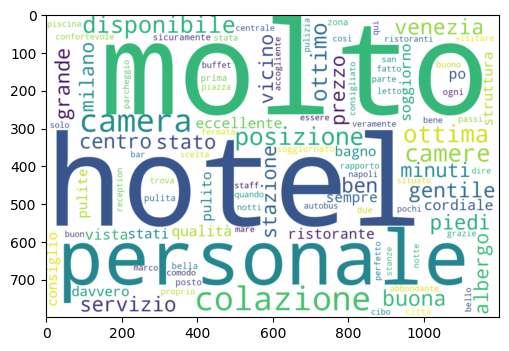

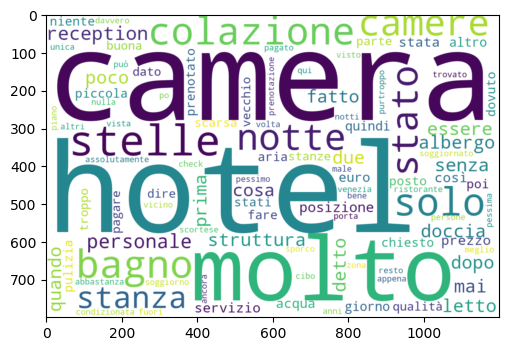

In [7]:
from wordcloud import WordCloud
def generate_wordcloud(X_tfidf,word_positions):
    tfidf_sum = np.sum(X_tfidf,axis=0)
    tfidf_sum = np.asarray(tfidf_sum).reshape(-1)
    top_indices = tfidf_sum.argsort()[-100:]
    term_weights = {word_positions[idx]: tfidf_sum[idx] for idx in top_indices}
    wc = WordCloud(width=1200,height=800,background_color="white")
    wordcloud = wc.generate_from_frequencies(term_weights)
    fig,ax = plt.subplots(dpi=100)
    ax.imshow(wordcloud,interpolation='bilinear')
    
word_positions={v: k for k,v in vectorizer.vocabulary_.items()}
generate_wordcloud(X[np.array(reviews['class'])=='pos'],word_positions)
generate_wordcloud(X[np.array(reviews['class'])=='neg'],word_positions)

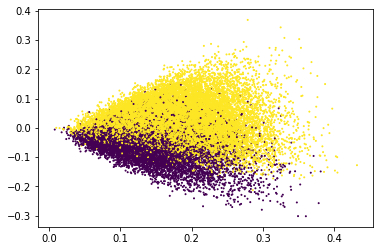

In [8]:
from sklearn.decomposition import TruncatedSVD
colors = list(map(lambda x: 1 if x=='pos' else 0, reviews['class']))
svd=TruncatedSVD(n_components=2, random_state=42)
X_svd=svd.fit_transform(X)
plt.scatter(X_svd[:,0],X_svd[:,1],c=colors,s=1)

In [9]:
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import ItalianStemmer
import re
import string

class LemmaTokenizer(object):
    def __init__(self):
        self.stemmer = ItalianStemmer()
    def __call__(self,doc):
        lemmas = []
        re_digit=re.compile("[0-9]")
        for t in word_tokenize(doc):
            t = t.strip()
            if t not in ["l'hotel",'hotel','camera','molto',"avere","essere"]:
                lemma = self.stemmer.stem(t)
                if lemma not in string.punctuation and not re_digit.match(lemma) and len(lemma)>1 and len(lemma)<15:
                    lemmas.append(lemma.lower())
        return lemmas

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords as sw
tot = reviews['spacy'].append(evaluation['spacy'])
tokenizer = LemmaTokenizer()
stopwords = list(sw.words('italian')) + ['abbi', 'abbiam', 'avemm', 'avend', 'avess', 'avesser', 'avessim', 'avest', 'avet', 'avev', 'avevam', 'avrann', 'avre', 'avrebb', 'avrebber', 'avrem', 'avremm', 'avrest', 'avret', 'avut', 'com', 'contr', 'ebber', 'eran', 'erav', 'eravam', 'essend', 'fac', 'facc', 'facess', 'facessim', 'facest', 'fann', 'far', 'farann', 'fare', 'farebb', 'farebber', 'farem', 'farest', 'fec', 'fecer', 'foss', 'fosser', 'fossim', 'fost', 'fumm', 'fur', 'hann', 'lor', 'nostr', 'perc', 'qual', 'quant', 'quell', 'quest', 'sar', 'sarann', 'sare', 'sarebb', 'sarebber', 'sarem', 'sarest', 'siam', 'sian', 'siat', 'siet', 'son', 'stand', 'stann', 'star', 'starann', 'stare', 'starebb', 'starebber', 'starem', 'starest', 'stav', 'stavam', 'stemm', 'stess', 'stesser', 'stessim', 'stest', 'stett', 'stetter', 'sti', 'stiam', 'tutt', 'vostr']+['avra', 'avro', 'fara', 'faro', 'perche', 'piu', 'sara', 'saro', 'stara', 'staro']
stopwords.remove('non')
vectorizer=TfidfVectorizer(tokenizer=tokenizer,stop_words=stopwords,ngram_range=(1,2),max_df=0.5,min_df=5)
tot = vectorizer.fit_transform(tot)
X = tot[:28754]
X_test = tot[28754:]

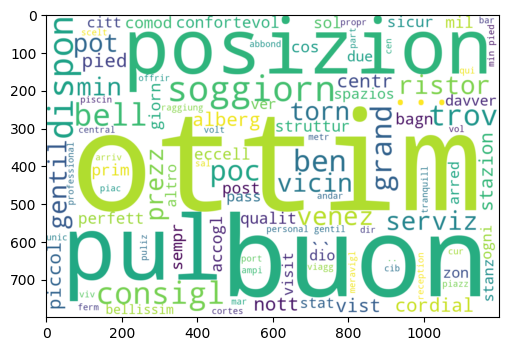

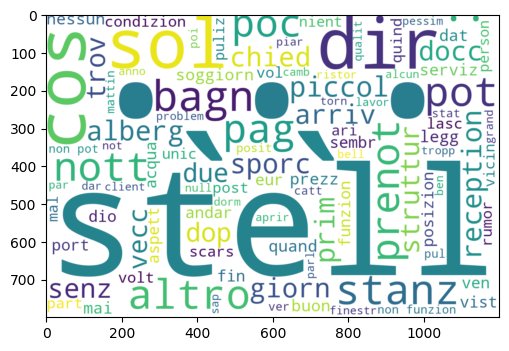

In [12]:
word_positions={v: k for k,v in vectorizer.vocabulary_.items()}
generate_wordcloud(X[np.array(reviews['class'])=='pos'],word_positions)
generate_wordcloud(X[np.array(reviews['class'])=='neg'],word_positions)

In [32]:
#classification
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier

clf = LinearSVC()
cross_val_score(clf, X, reviews['class'], cv=3, scoring='f1_macro').mean()

0.9609391212982338

In [27]:
from sklearn.model_selection import GridSearchCV
clf = LinearSVC()
param_grid = {'loss': ['hinge','squared_hinge'],'C': [1,0.1,0.01,10,100,1000],'tol': [0.1,0.001,0.0001],'class_weight': ['balanced',None]}
gridsearch = GridSearchCV(clf, param_grid, scoring='f1_macro', cv=3)
gridsearch.fit(X, reviews['class'])
best_configured_model = gridsearch.best_estimator_
best_configured_model

c:\users\macco\appdata\local\programs\python\python37\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=3000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
X_train, X_val, y_train, y_val = train_test_split(X, reviews['class'], test_size=0.2)
clf = LinearSVC(class_weight='balanced')
clf.fit(X_train,y_train)
ypred = clf.predict(X_val)

conf_mat = confusion_matrix(y_val, ypred)
print(conf_mat)
print(f1_score(y_val,ypred,average='macro'))

[[1797   94]
 [  99 3761]]
0.9620099870947117


In [20]:
def tocsv(labels):
    with open("./Desktop/labels.csv", "w+") as f:
        f.write("Id,Predicted\n")
        for i in range(0,len(labels)):
            f.write(f"{i},{labels[i]}\n")
        f.close
clf = LinearSVC(class_weight='balanced')
clf.fit(X,reviews['class'])
ypred = clf.predict(X_test)
tocsv(ypred)